#### 使用适应性耦合强度，和资源限制，实现瞬态的爆炸同步(极端同步事件)
ref : A. Ranjan, et al. Propagation of transient explosive synchronization in a mesoscale mouse brain network model of epilepsy, Network Neuroscience 8, 883–901 (2024).

model: Kuramoto model

network: 小世界网络 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import random
import networkx as nx
from scipy.sparse import coo_matrix
import scipy.sparse as sp
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
seed = 0
random.seed(seed)
np.random.seed(seed)

##### 模型算法

In [3]:
# Kuramoto 模型
@njit
def kuramoto(vars, t, omega, r_local, alpha, beta, lam_0, pre_ids, post_ids):
    """
    Kuramoto 模型的微分方程。
    args:
        vars: 相位
        t: 当前时间
        omega: 自然频率
        r_local: 局部秩序
    """
    res = np.zeros_like(vars)

    Theta, Lam = vars

    currents = np.sin(Theta[pre_ids]- Theta[post_ids])

    num_nodes = len(Theta)
    
    I_couple = np.bincount(post_ids, weights=currents, minlength=num_nodes)

    dvars_dt = omega + Lam* r_local * I_couple

    dLam_dt = alpha * (lam_0 - Lam) - beta * r_local

    res[0] = dvars_dt

    res[1] = dLam_dt

    return res

@njit
def RK4(fun, x0, t, dt, *args):
    """
    使用 Runge-Kutta 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程
        x0: 上一个时间单位的状态变量
        t: 运行时间
        dt: 时间步长
    :return:
        x0 (numpy.ndarray): 下一个时间单位的状态变量
    """
    k1 = fun(x0, t, *args)
    k2 = fun(x0 + (dt / 2.) * k1, t + (dt / 2.), *args)
    k3 = fun(x0 + (dt / 2.) * k2, t + (dt / 2.), *args)
    k4 = fun(x0 + dt * k3, t + dt, *args)

    x0 += (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

@njit
def Heun(fun, x0, t, dt, *args):
    """
    使用 Heun 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程函数，形式为 fun(x, t, *args)
        x0: 上一个时间单位的状态变量 (numpy.ndarray)
        t: 当前时间
        dt: 时间步长
    return:
        x1 (numpy.ndarray): 下一个时间单位的状态变量
    """
    # 计算当前点的斜率
    k1 = fun(x0, t, *args)
    
    # 使用 Euler 法预测值
    x_pred = x0 + dt * k1
    
    # 在预测点上计算新的斜率
    k2 = fun(x_pred, t + dt, *args)
    
    # 加权平均斜率得到新的状态
    x0 += 0.5 * dt * (k1 + k2)
    return x0

@njit
def Euler(fun, x0, t, dt, *args):
    """
    使用 euler 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程
        x0: 上一个时间单位的状态变量
        t: 运行时间
        dt: 时间步长
    :return: 
        x0 (numpy.ndarray): 下一个时间单位的状态变量
    """
    # 计算下一个时间单位的状态变量
    x0 += dt * fun(x0, t, *args)
    return x0


In [4]:
method = Euler

##### 统计量

In [5]:
@njit
def order_parameter(vars):
    """
    计算系统的序参量。
    args:
        vars: 相位
    return:
        r (float): 序参量
    """
    N = len(vars)
    r = np.abs(np.sum(np.exp(1j * vars)) / N)
    return r

@njit
def local_order_parameter(vars, pre_ids, post_ids, degree_lit):
    """
    计算系统的局部序参量。
    args:
        vars: 相位
        pre_ids: 前节点id
        post_ids: 后节点id
        degree_lit: 节点度
    return:
        r (float): 局部序参量
    """
    N = len(vars)

    # 计算复指数
    r_temp = np.exp(1j * vars[pre_ids])

    # 分别处理实部和虚部
    real_part = r_temp.real
    imag_part = r_temp.imag

    # 使用 np.bincount 分别计算实部和虚部的累加
    sum_real = np.bincount(post_ids, weights=real_part, minlength=N)
    sum_imag = np.bincount(post_ids, weights=imag_part, minlength=N)

    # 合并为复数
    # r_sum = sum_real + 1j * sum_imag
    r_sum_abs = np.sqrt(sum_real**2 + sum_imag**2)
    
    r_local = r_sum_abs / degree_lit

    return r_local

In [6]:
# 创建网络
@njit
def net(N, A_adj, lam_0, cal_n=1000_00):
    # =================== 节点参数 =================== 
    # 自然频率
    omega = np.random.uniform(-1., 1., N)
    # 初始相位
    Theta = np.random.uniform(-np.pi, np.pi, N)
    # 耦合强度
    Lam = np.zeros(N)

    vars_nodes = np.vstack((Theta, Lam))

    dt = 0.01

    # =================== 网络参数 ===================
    post_ids, pre_ids = np.nonzero(A_adj)
    degrees = A_adj.sum(axis=1)

    t = 0.

    # =================== 资源限制参数 ===================
    alpha = 0.01
    beta = 0.002

    # 初始化(网络)
    for i in range(200_00):
        r_local = local_order_parameter(vars_nodes[0], pre_ids, post_ids, degrees)

        method(kuramoto, vars_nodes, t, dt, omega, r_local, alpha, beta, lam_0, pre_ids, post_ids)

    # =================== 计算 ===================
    r_t_list = np.zeros(cal_n)

    r = 0.
    # cal_n = 1000_00
    for i in range(cal_n):
        r_local = local_order_parameter(vars_nodes[0], pre_ids, post_ids, degrees)

        method(kuramoto, vars_nodes, t, dt, omega, r_local, alpha, beta, lam_0, pre_ids, post_ids)

        t += dt

        # r += order_parameter(vars_nodes)/cal_n
        r_t = order_parameter(vars_nodes[0])

        r_t_list[i] = r_t

    return r_t_list


In [7]:
N = 400
m = 45

G = nx.watts_strogatz_graph(N, m, p=0.232)
A_adj = nx.to_numpy_array(G)  # 邻接矩阵

In [8]:
lam_0 = 0.11
r_t_list = net(N, A_adj, lam_0, cal_n=1200_00)

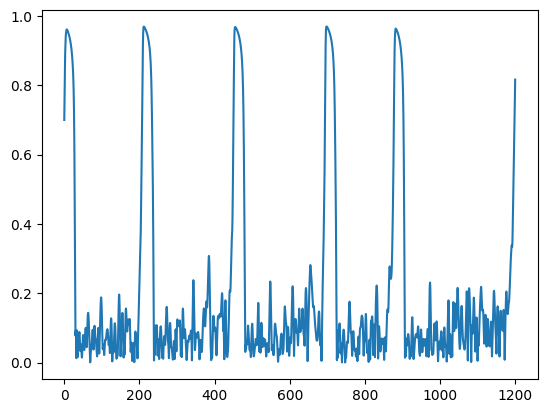

In [9]:
plt.plot(np.arange(len(r_t_list))*0.01, r_t_list)
plt.show()

In [10]:
@njit(parallel=True)
def Parallel_net(N, A_adj, lam_0_list):
    len = lam_0_list.shape[0]
    cal_n=500_00
    results = np.zeros((len, cal_n))

    for i in prange(len):
        result = net(N, A_adj, lam_0_list[i], cal_n=cal_n)
        results[i] = np.asarray(result)

    return results

In [11]:
lam_0_list1 = np.arange(0.01, 0.03, 0.001)
lam_0_list2 = np.arange(0.03, 0.05, 0.001)
lam_0_list3 = np.arange(0.05, 0.07, 0.001)
lam_0_list4 = np.arange(0.07, 0.09, 0.001)
lam_0_list5 = np.arange(0.09, 0.11, 0.001)
lam_0_list6 = np.arange(0.11, 0.13, 0.001)
lam_0_list7 = np.arange(0.13, 0.15, 0.001)
lam_0_list8 = np.arange(0.15, 0.17, 0.001)
lam_0_list9 = np.arange(0.17, 0.19, 0.001)
lam_0_list10 = np.arange(0.19, 0.21, 0.001)
lam_0_list11 = np.arange(0.21, 0.23, 0.001)
lam_0_list12 = np.arange(0.23, 0.25, 0.001)
lam_0_list13 = np.arange(0.25, 0.27, 0.001)
lam_0_list14 = np.arange(0.27, 0.29, 0.001)
lam_0_list15 = np.arange(0.29, 0.31, 0.001)

lam_0_list = np.concatenate([lam_0_list1, lam_0_list2, lam_0_list3, lam_0_list4, lam_0_list5, lam_0_list6, lam_0_list7, lam_0_list8, lam_0_list9, lam_0_list10, lam_0_list11, lam_0_list12, lam_0_list13, lam_0_list14, lam_0_list15])

In [12]:
results1 = Parallel_net(N, A_adj, lam_0_list1)
results2 = Parallel_net(N, A_adj, lam_0_list2)
results3 = Parallel_net(N, A_adj, lam_0_list3)
results4 = Parallel_net(N, A_adj, lam_0_list4)
results5 = Parallel_net(N, A_adj, lam_0_list5)
results6 = Parallel_net(N, A_adj, lam_0_list6)
results7 = Parallel_net(N, A_adj, lam_0_list7)
results8 = Parallel_net(N, A_adj, lam_0_list8)
results9 = Parallel_net(N, A_adj, lam_0_list9)
results10 = Parallel_net(N, A_adj, lam_0_list10)
results11 = Parallel_net(N, A_adj, lam_0_list11)
results12 = Parallel_net(N, A_adj, lam_0_list12)
results13 = Parallel_net(N, A_adj, lam_0_list13)
results14 = Parallel_net(N, A_adj, lam_0_list14)
results15 = Parallel_net(N, A_adj, lam_0_list15)

In [13]:
results = np.vstack([results1, results2, results3, results4, results5, results6, results7, results8, results9, results10, results11, results12, results13, results14, results15])

In [14]:
x_axis = np.repeat(lam_0_list.reshape(-1, 1), results.shape[1], axis=1).flatten()
y_axis = results.flatten()

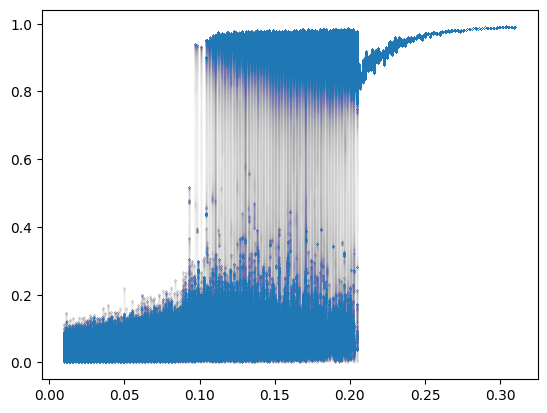

In [15]:
plt.plot(x_axis, y_axis, 'o', markersize=0.002, alpha=0.5)
plt.show()